# Ojo cuidao!!!

Que es estado entrenando una red, que esta dedicada a aprender sobre UNA SERIE TEMPORAL, a que prediga sobre muchas de estas, las cuales no compartían nada, solo que eran sinusoidales, pero con diferente frecuencia!!   

Vale, ahora el tema es darle una serie temporal constante, con un patron constante, y enventanárselo para que tenga bastantese muestras. No se, 600? Por ejemplo.  

In [1]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

In [2]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)#+5


In [3]:
def add_global_anom(x,anoms=1,magnitud=None):
    x=x.to(float)
    #añade en una disposiciónaleatoria, un pico del orden de las obervaciones
    if magnitud is None:
        magnitud=x.max().item()-x.min().item()
    index=torch.from_numpy(np.random.choice(np.arange(0,x.size()[0]),size=anoms,replace=False))
    x[index]= torch.from_numpy(magnitud*np.random.randn(anoms))+x[index]
    return x
    

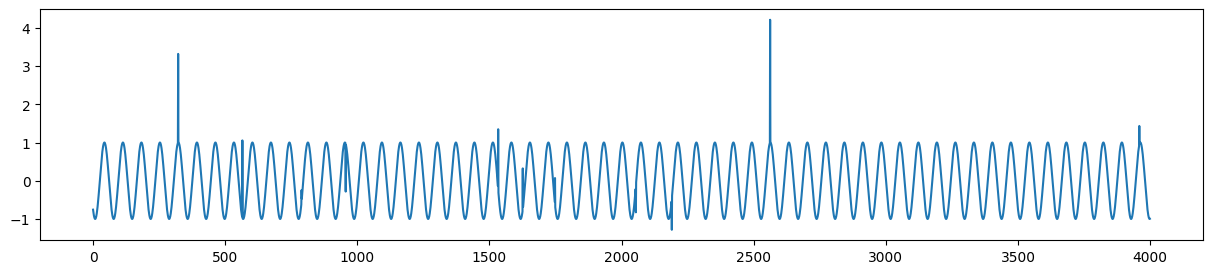

In [4]:
y=add_global_anom(sinne(4000,sf=0.01,f=0.007,phase=4),11,1.5)
plt.figure(figsize=(15,3))
plt.plot(y)

In [5]:
#ahora le hacemos el slicing
y_windowed = np.lib.stride_tricks.sliding_window_view(y,(100)).copy()
print(y_windowed.shape)

(3901, 100)


Y ahora el generador de datos. Le decimos que nos devuelva un batch de datos y nos lo da.

In [6]:
class Data_anomSine(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,array):
        super().__init__()
        #lo recibimos sin la ultima dimension [1]
        self.array=torch.from_numpy(array).unsqueeze(-1)

    def __len__(self):

        return self.array.shape[0]


    def __getitem__(self, index):
        return self.array[index]


In [7]:
win_size=100
data=Data_anomSine(y_windowed)

dataloader=DataLoader(data,batch_size=32,shuffle=True)

In [8]:
def warmup_and_decay_learning_rate(optimizer, epoch, init_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        lr = init_lr * (epoch / warmup_epochs)
        print('Warmup: Updating learning rate to {}'.format(lr))
    else:
        decay_epochs = total_epochs - warmup_epochs
        decay_rate = 1e-7+(epoch - warmup_epochs) / decay_epochs
        lr = init_lr * (1 - decay_rate)
        print('Decay: Updating learning rate to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr




def count_parameters(model):
    
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total
#count_parameters(modelo)

## Entrenamiento
Añadimos en el entrenamiendo dos fases, una de mini y otra de max

Con el output tenemos que sacar: el error de reconstrucción y el AssDiss, y luego sacar dos function loses, una donde se minimiza y otra donde de maximiza.  

El calculo de las assdis lo vamos a poner en una funcion. 

In [9]:

def clip_gradients(model, max_norm, norm_type=2):
    """
    Clip gradients of the model parameters.

    Args:
        model (torch.nn.Module): The neural network model.
        max_norm (float): The maximum allowed norm for the gradients.
        norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
    """
    # Recupera todos los gradientes de los parámetros del modelo
    gradients = [param.grad for param in model.parameters() if param.grad is not None]

    # Calcula la norma total de los gradientes
    total_norm = torch.norm(torch.stack([torch.norm(grad, norm_type) for grad in gradients]), norm_type)

    # Calcula el factor de escalado para recortar los gradientes
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        # Aplica el factor de escalado a los gradientes
        for grad in gradients:
            grad.mul_(clip_coef)




# def layer_association_discrepancy( Pl, Sl):
#     #Pl y Sl viene con dimension B,Head,Height,Width
#     B,Head,Height,_ = Pl.shape
#     result=torch.zeros(B,Head,Height)
#     for batch_size in range(B):
#         for head_size in range(Head):
#             rowwise_kl = lambda row: (F.kl_div(Pl[batch_size,head_size,row, :], Sl[batch_size,head_size,row, :]) + F.kl_div(Sl[batch_size,head_size,row, :], Pl[batch_size,head_size,row, :]))
#             ad_vector = torch.concat([rowwise_kl(row).unsqueeze(0) for row in range(Height)])
#             result[batch_size,head_size,:]=ad_vector
#     return result

def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)#se suma par acalcular la KL y luego se hace la media para eliminar la dimension HEAD, esto no se me ocurre una mejor forma. 



# def layer_association_discrepancy(Pl, Sl):
#     # Pl y Sl vienen con dimension B, Head, Height, Width
#     B, Head, Height, _ = Pl.shape

#     # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
#     kl1 = F.kl_div(Pl, Sl, reduction='none').mean(dim=-1)
#     kl2 = F.kl_div(Sl, Pl, reduction='none').mean(dim=-1)

#     # Sumar los KL Divergence calculados
#     ad_vector = kl1 + kl2

#     return ad_vector

def layer_association_discrepancy(Pl, Sl):
    # Pl y Sl vienen con dimension B, Head, Height, Width
    B, Head, Height, _ = Pl.shape

    # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
    kl1 = my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
    kl2 = my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))

    # Sumar los KL Divergence calculados
    ad_vector = kl1 + kl2

    return ad_vector



def association_discrepancy( P_list, S_list):

    return torch.stack([layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])
    #se hace la media sobre todos los blocks porque si, porque sino de que manera ibamos a obtener un resumen de la cantidad que queremos, para enviar los gradientes. 

# (1 / len(P_list)) * sum(
#         [
#             torch.mean(layer_association_discrepancy(P, S),axis=0)#hacemos la media sobre todas las cabezas
#             for P, S in zip(P_list, S_list)
#         ]
#     )

def loss_function( x_hat, P_list, S_list, lambda_, x):
    frob_norm = ((x_hat - x)**2).mean()   #usamo MSE  #torch.linalg.matrix_norm(x_hat - x, ord="fro").mean() #norm L2 
    diss_norm=torch.mean(association_discrepancy(P_list, S_list)) #torch.linalg.norm(, ord=1) # le añado esto para que se normaliza acros muestras 
    print(frob_norm,diss_norm)
    return (frob_norm.item(),diss_norm.item()),frob_norm - (lambda_* diss_norm) #hacemos la suma de todos los valores absolutos y dividimos todo por el batchsize
    

def min_loss(output,P_layers,S_layers, x,lambda_):
    P_list = P_layers
    S_list = [S.detach() for S in S_layers]
    lambda_ = -lambda_
    _,loss_value=loss_function(output, P_list, S_list, lambda_, x)
    return loss_value

def max_loss(output,P_layers,S_layers,x,lambda_):
    P_list = [P.detach() for P in P_layers]
    S_list = S_layers
    lambda_ = lambda_
    datails,loss_value=loss_function(output, P_list, S_list, lambda_, x)
    return datails,loss_value

(32, 100, 1)


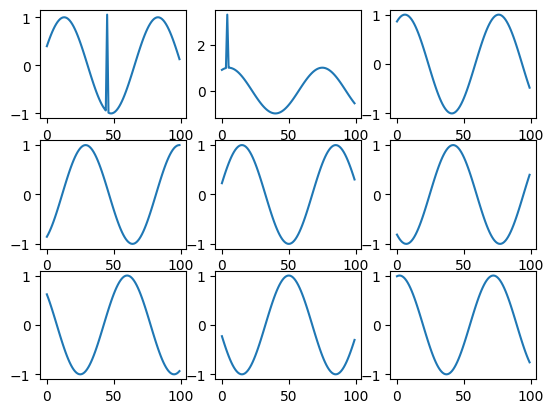

In [10]:
x_aux=next(iter(dataloader))
x_aux=x_aux.cpu().detach().numpy()
print(x_aux.shape)
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.plot(x_aux[i])

In [11]:
modelo=AnomalyTransformer.AnomalyTransformer(100, 1, 1, d_model=64, n_heads=2, e_layers=2, d_ff=32,
                          dropout=0.1, activation='relu', output_attention=True)
modelo.cuda()

count_parameters(modelo)

Total trainable parameters: 43076


43076

In [12]:
#veamos a ver si hay nans en los parámetros 
a=list(modelo.parameters())
if len([i for i in a if i.isnan().sum().item()!=0])>0:
    print("HAY NANS")

In [13]:
def get_gradients(model):
    """
    Get all gradients of the model parameters.

    Args:
        model (torch.nn.Module): The neural network model.

    Returns:
        List[Tensor]: A list of gradient tensors for each model parameter.
    """
    gradients = [param.grad for param in model.parameters() if param.grad is not None]
    return gradients


def xavier_initialization(model):
    for module in model.modules():
        if hasattr(module, 'weight') and module.weight is not None and module.weight.dim() >= 2:
            nn.init.xavier_uniform_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                nn.init.constant_(module.bias, 0)
    return model



# gradients = get_gradients(modelo)
# gradients


In [14]:
modelo=xavier_initialization(modelo)

In [15]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.train()
lambda_=1e-3
#criterion=nn.MSELoss()
loss_frob_diss=[]

# Entrenamiento
num_epochs = 125
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i, (inputs) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        prior=[j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100) for j in prior] #hacemos todo el lio este para dividir cada elemento por la suma de su fila, y hacerlo para ca bloque 
        loss_min = min_loss(outputs,prior,series, inputs,lambda_)
        details,loss_max = max_loss(outputs,prior,series, inputs,lambda_)
        loss_frob_diss.append(list(details))
        # Backward y optimización
        loss_min.backward(retain_graph=True)
        loss_max.backward()
        #clip_gradients(modelo, max_norm=1)
        #loss=criterion(outputs,inputs)
        #loss_frob_diss.append(loss.item())
        #loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #del inputs 
        #torch.cuda.empty_cache()
        #gc.collect()

        warmup_and_decay_learning_rate(optimizer, epoch, 1e-3,7, num_epochs)
        # Printear resultados
        #print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss_min: {loss_min.item():.4f}, Loss_max: {loss_max.item():.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss_max.item():.4f}")

print("Entrenamiento finalizado")

Epoch: 0
tensor(3.2362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.8576, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.2362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.8576, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/125], Step [1/122], Loss: 3.2283
tensor(1.7665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.8077, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.8077, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/125], Step [2/122], Loss: 1.7587
tensor(1.7525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.8119, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.8119, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/125], Step [3/122], Loss: 1.7447
tensor(1.8023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.7

In [16]:
#modelo.cuda()
a=next(iter(dataloader))
a1=a.float().to("cuda:0")
modelo.eval()
y=modelo(a1)


In [17]:
z=y[0].squeeze().cpu().detach().numpy()
series_aux=y[1][0].squeeze().cpu().detach().numpy()
prior_aux=y[2][0].squeeze().cpu().detach().numpy()
b=a1.squeeze().cpu().detach().numpy()

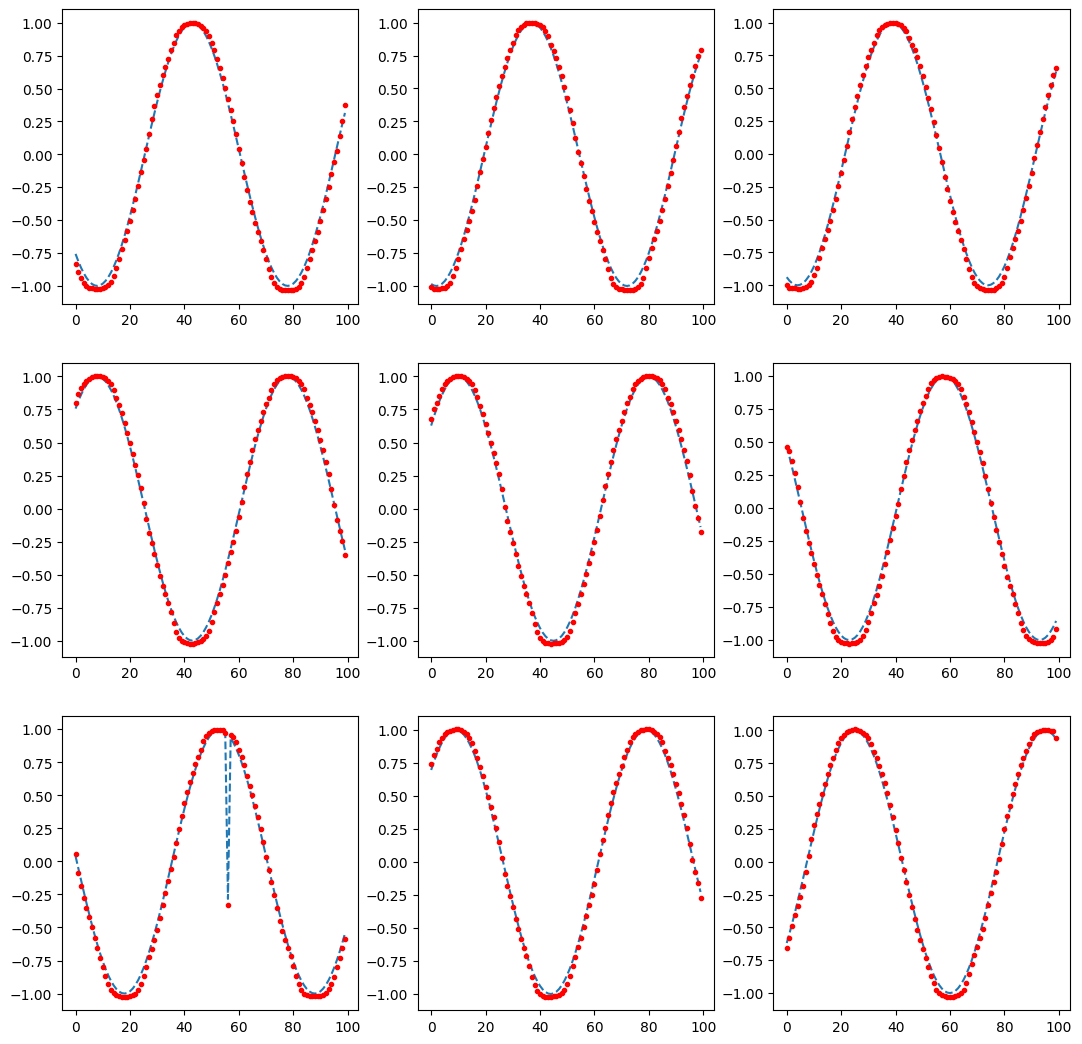

In [18]:
plt.figure(figsize=(13,13))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(b[i],"--")
    plt.plot(z[i],".r")


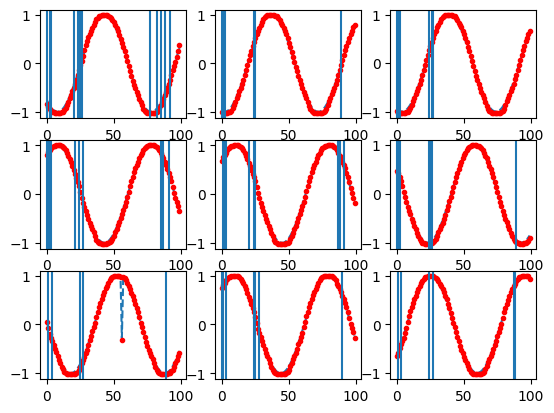

In [19]:
for j in range(9):
    plt.subplot(3,3,j+1)
    a=series[0][j,0].cpu().detach().numpy()
    indx=np.unique(np.argwhere(a>np.percentile(a,99))[:,1])
    plt.plot(b[j],"--")
    plt.plot(z[j],".r")
    for i in indx:
        plt.axvline(i)

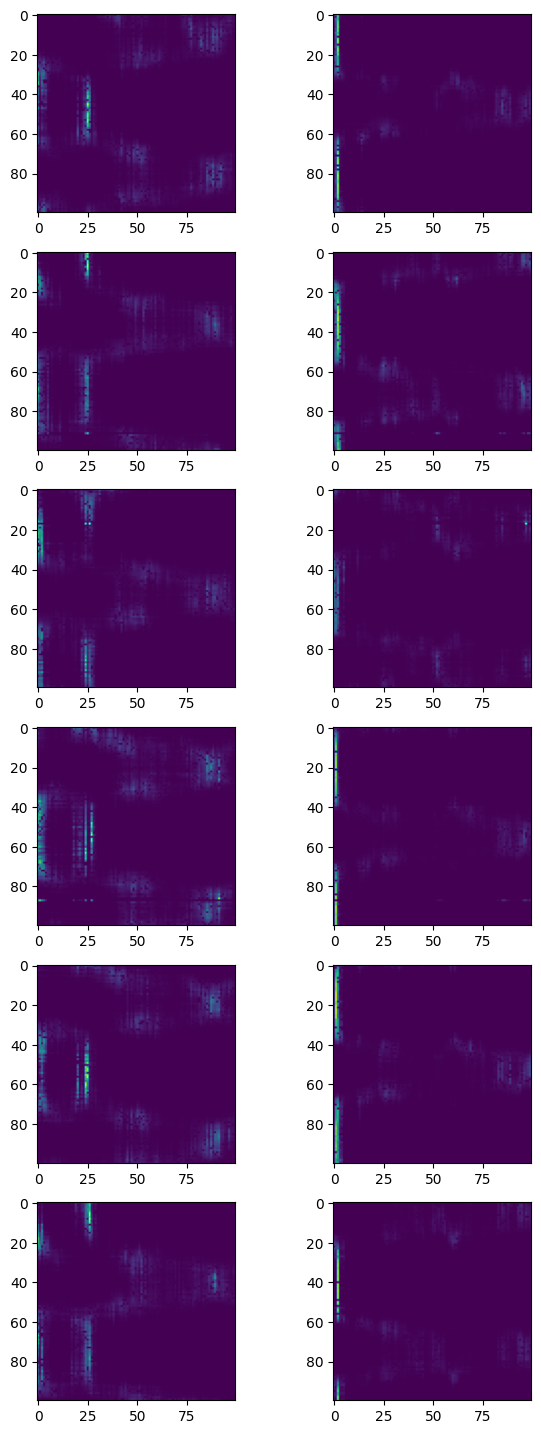

In [20]:
#plot el asociation
plt.figure(figsize=(7,18))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    plt.imshow(series[0][i,0].cpu().detach().numpy())
    plt.subplot(6,2,i*2+2)
    plt.imshow(series[0][i,1].cpu().detach().numpy())

In [29]:
ass=association_discrepancy(y[2],y[1]).cpu().detach().numpy()
ass.shape

(32, 100)

In [30]:
part_a=F.softmax(-association_discrepancy(y[2],y[1]),dim=-1)
part_b=((a1-y[0])**2).squeeze()
crit=part_a*part_b
crit_array=crit.cpu().detach().numpy()

In [31]:
np.argwhere(crit_array>0.0001)[:,0]

array([ 0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18

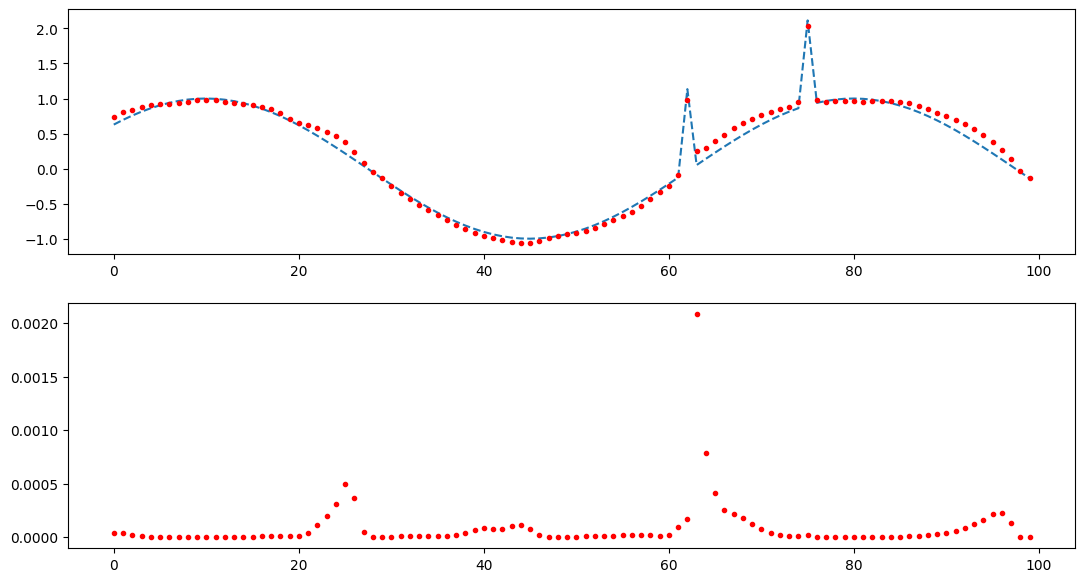

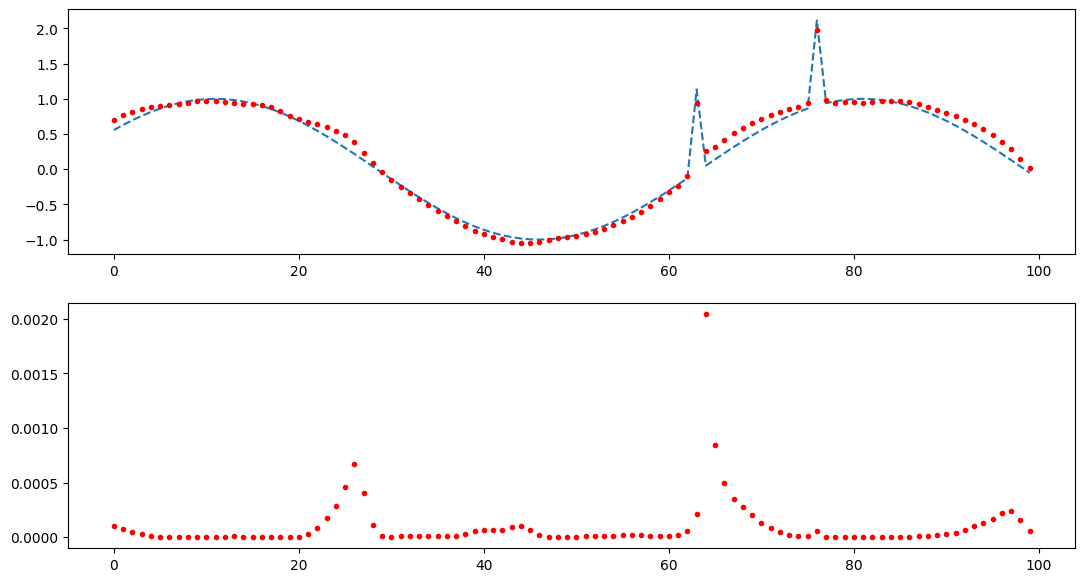

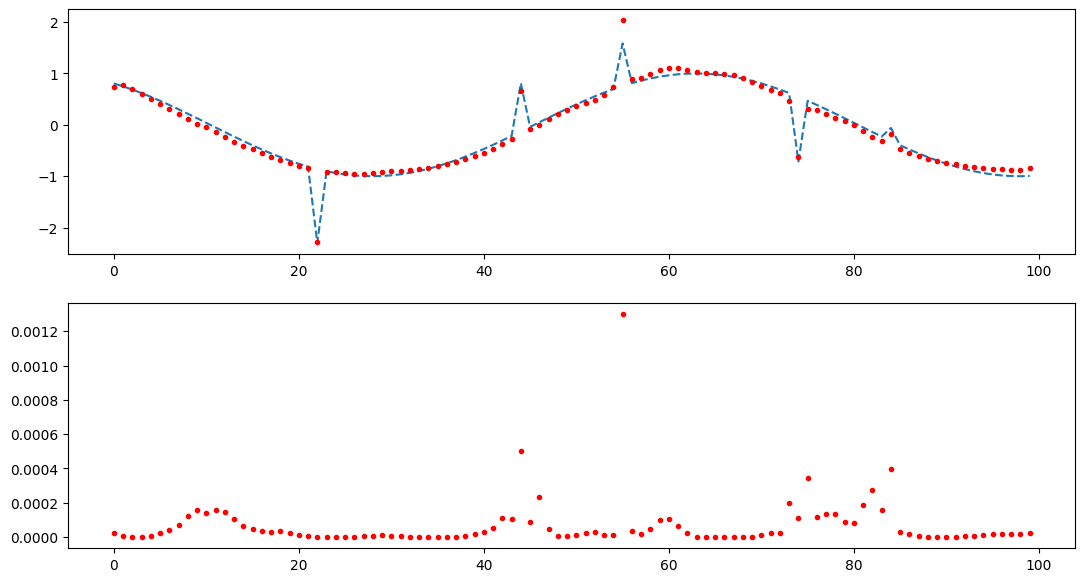

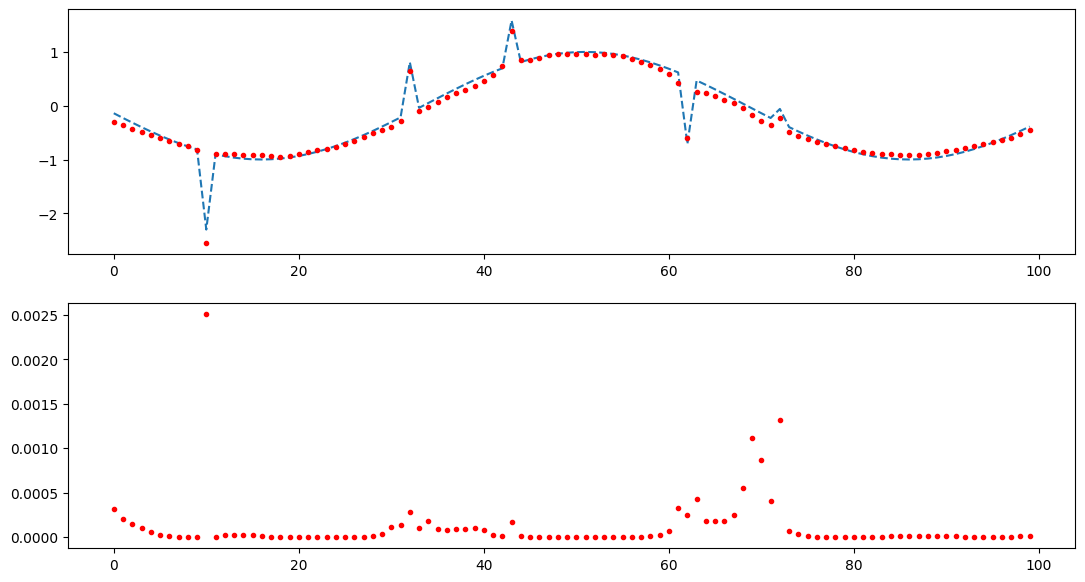

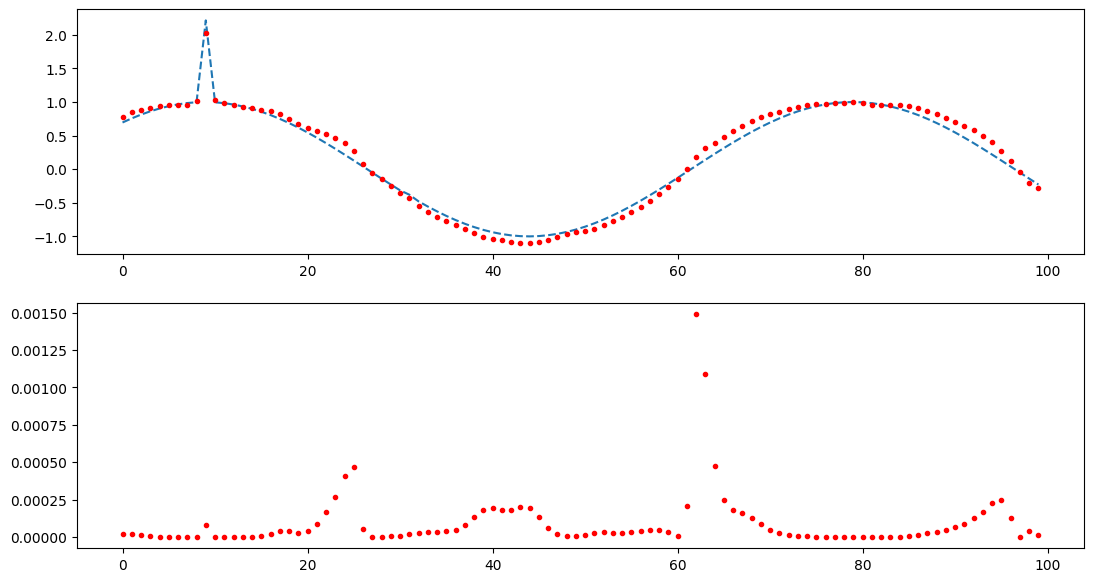

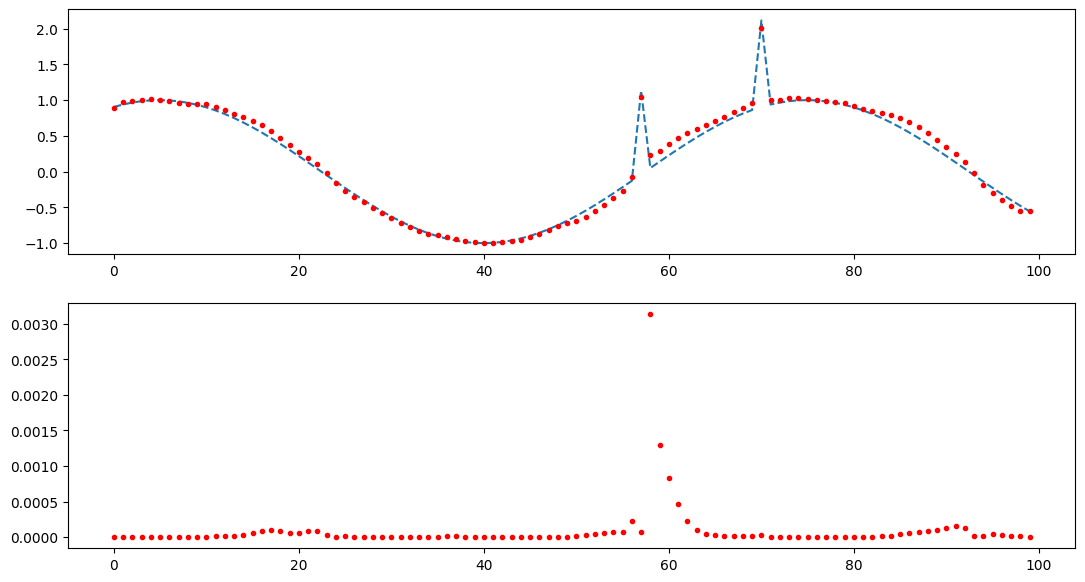

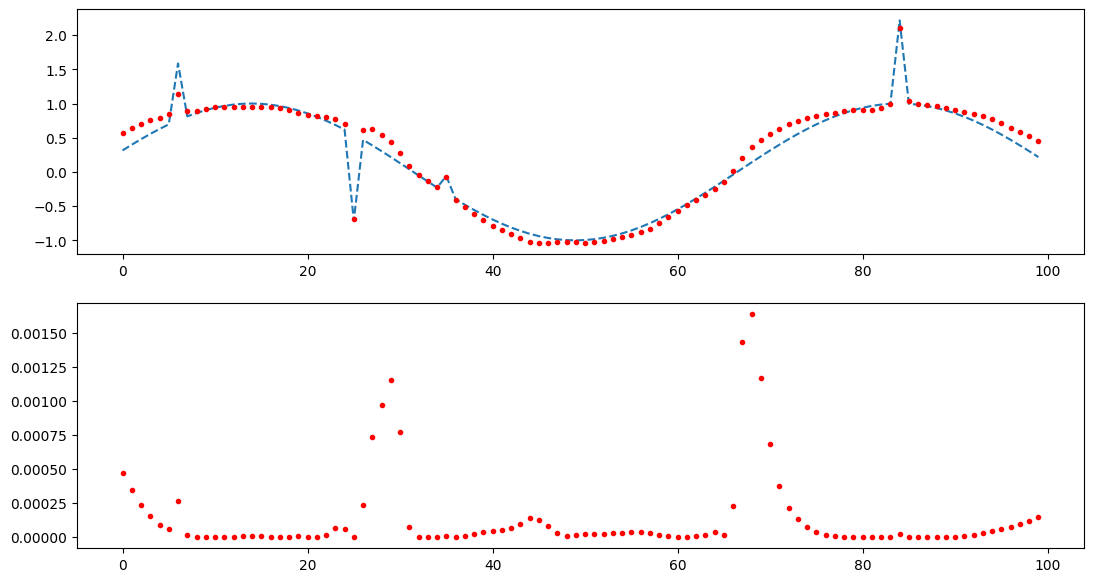

In [32]:
for n in np.unique(np.argwhere(crit_array>0.001)[:,0]):
    plt.figure(figsize=(13,7))
    plt.subplot(2,1,1)
    plt.plot(b[n],"--")
    plt.plot(z[n],".r")
    plt.subplot(2,1,2)
    #plt.plot(ass[n],".r")
    plt.plot(crit_array[n],".r")

/tmp/ipykernel_1067603/908250696.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(13,7))


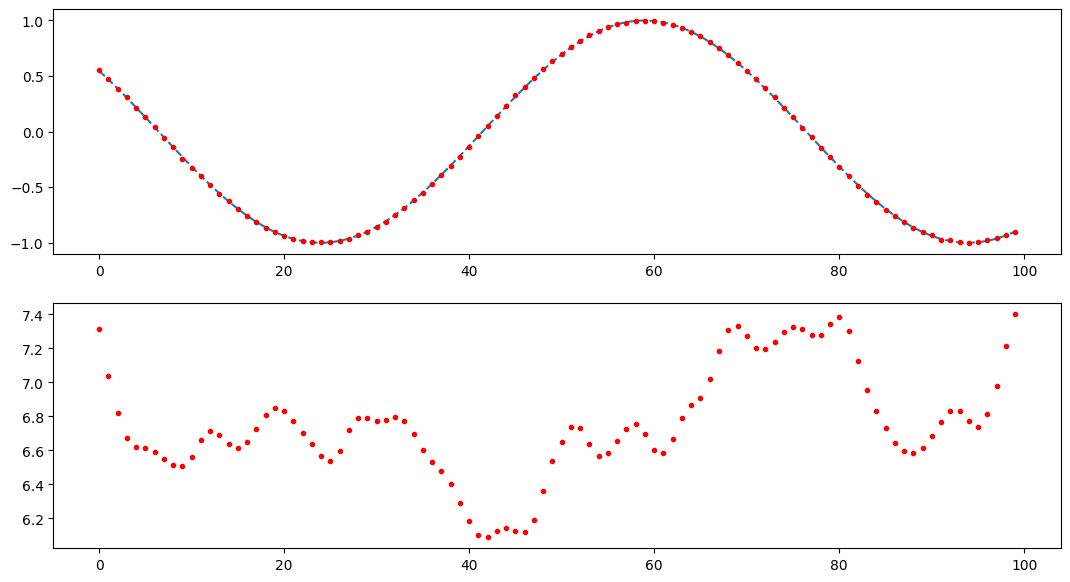

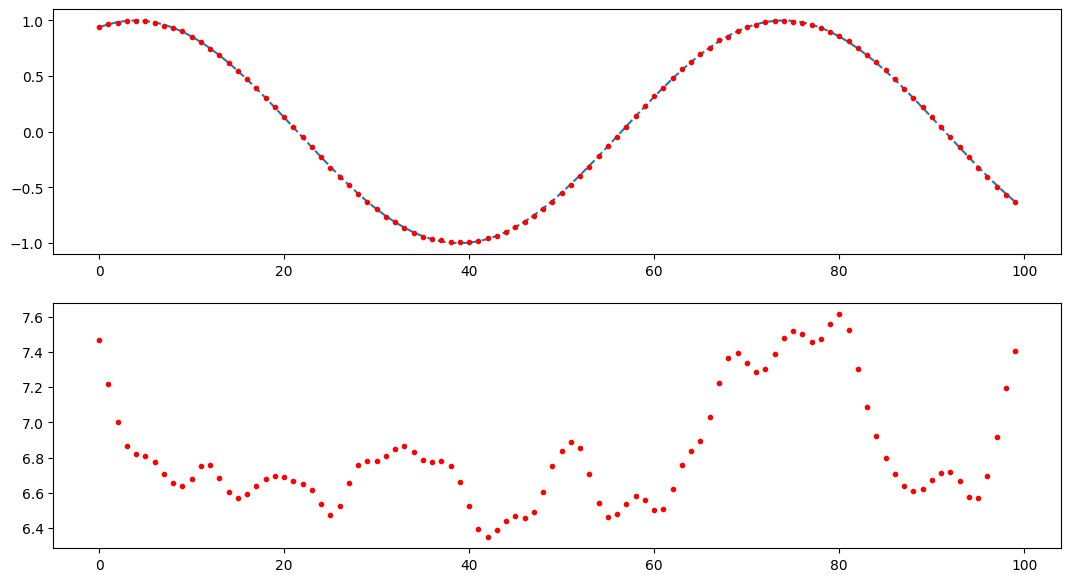

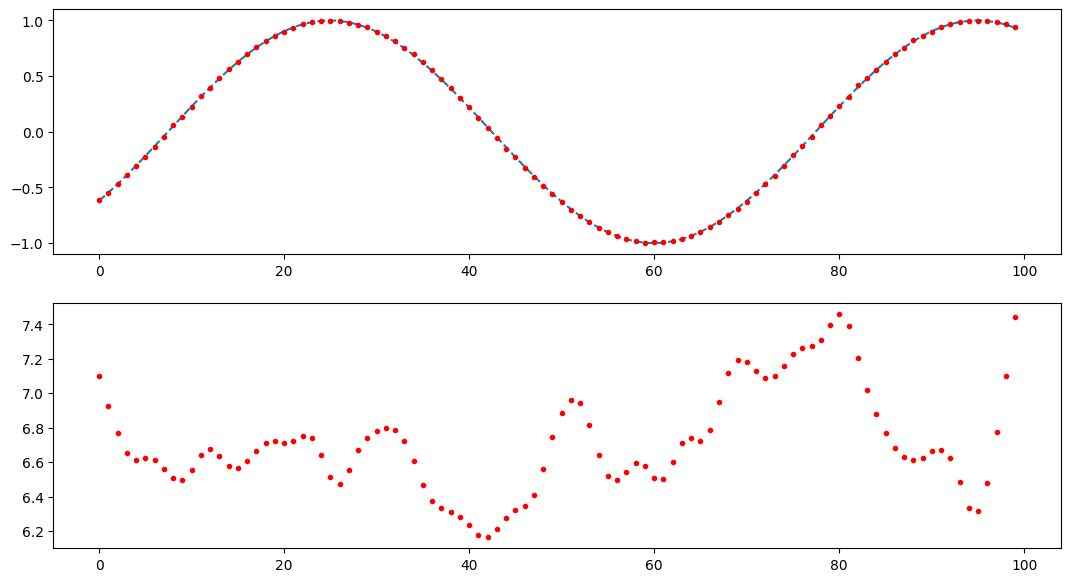

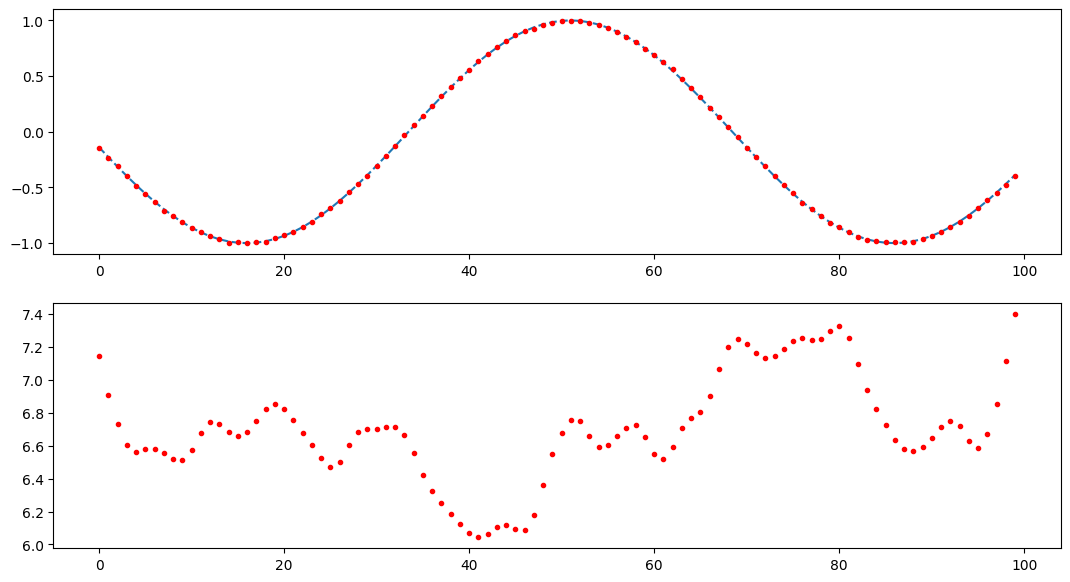

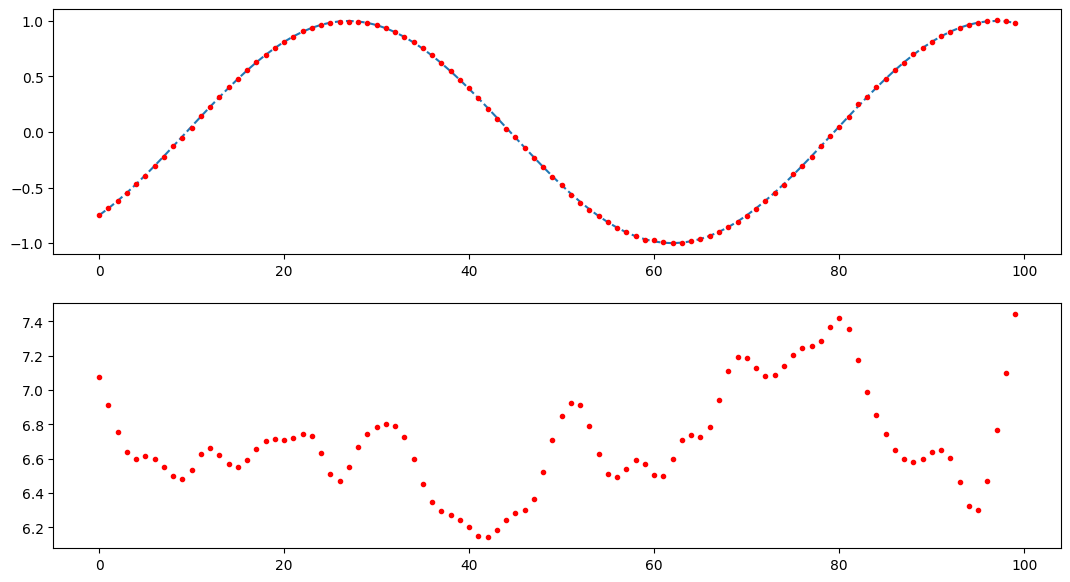

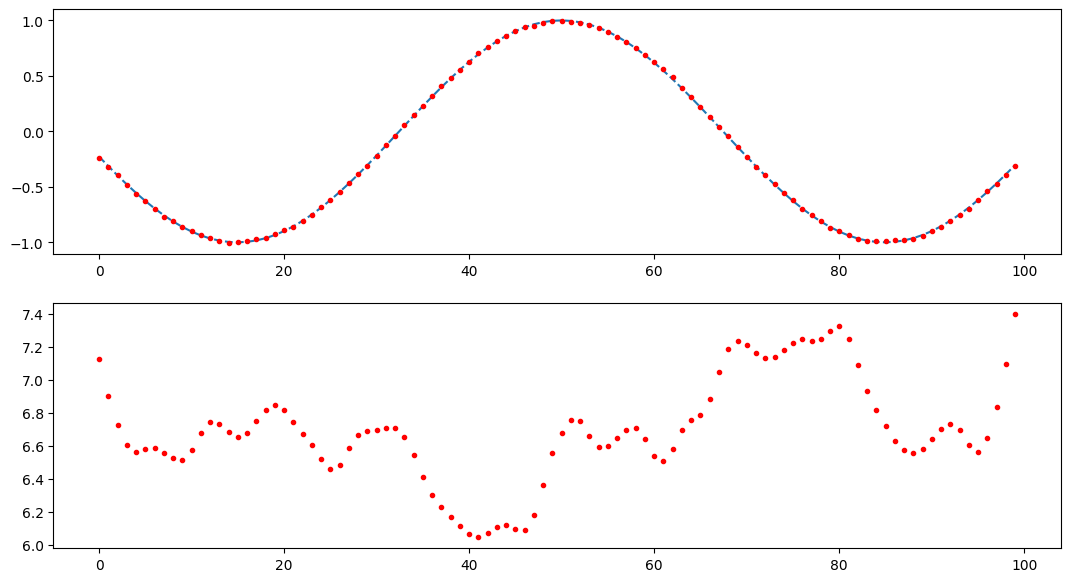

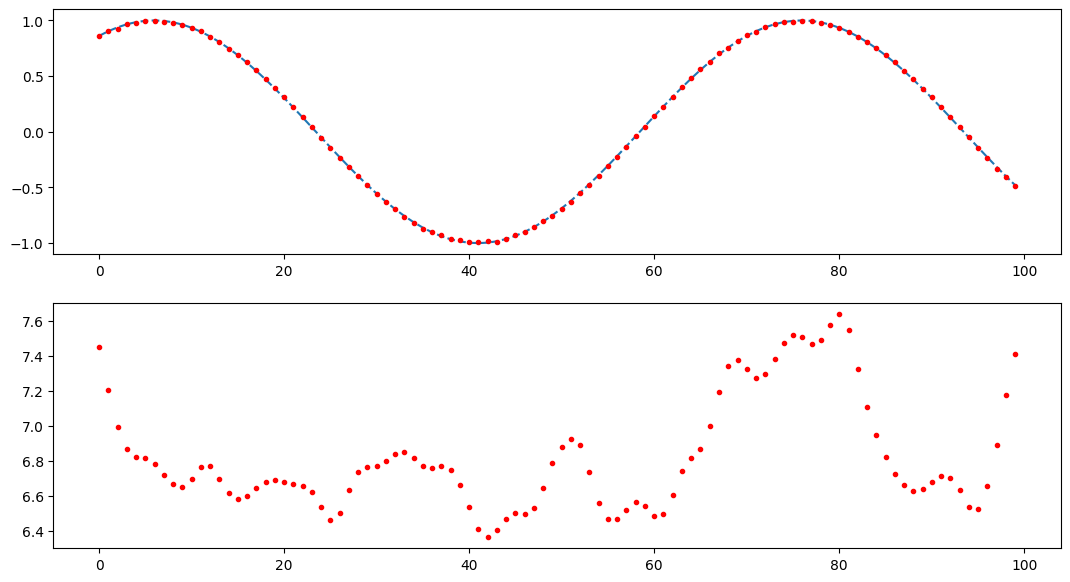

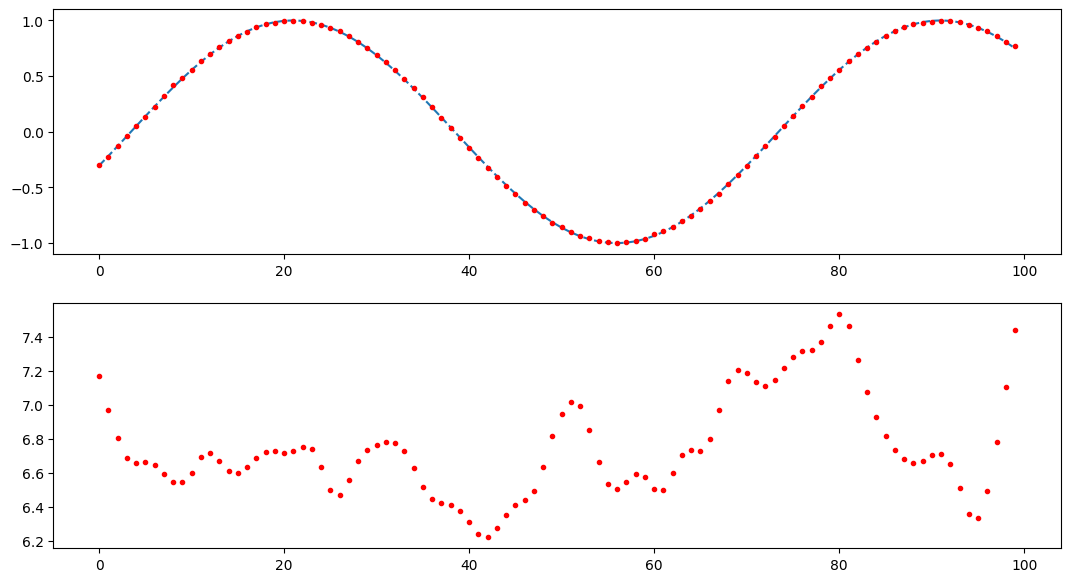

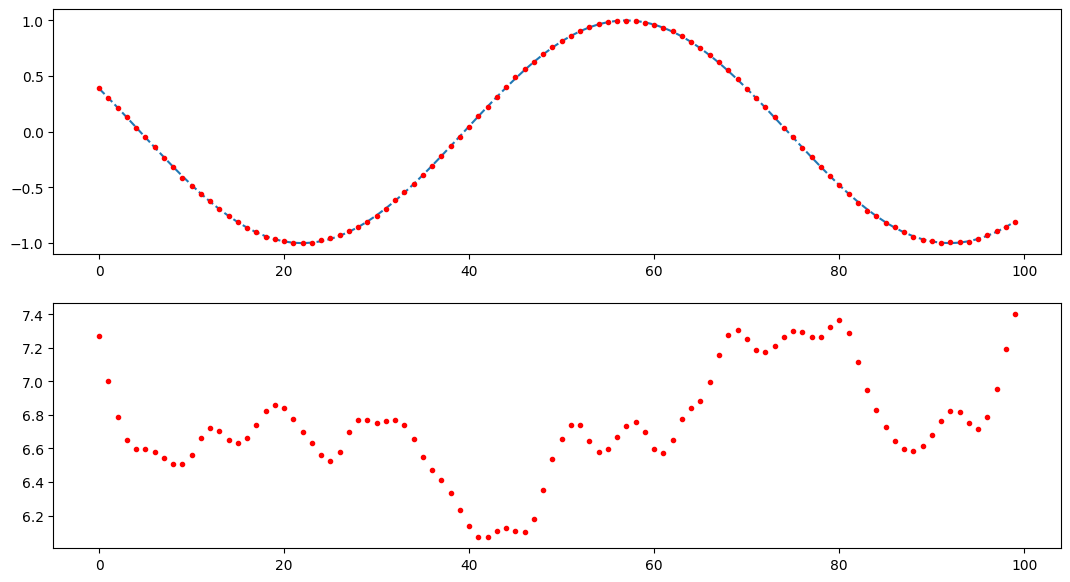

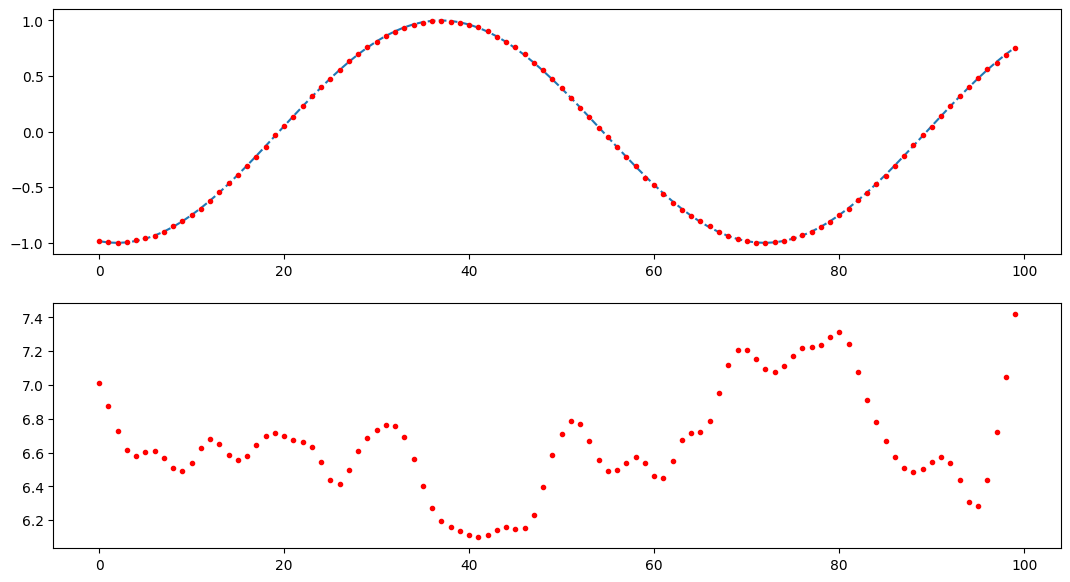

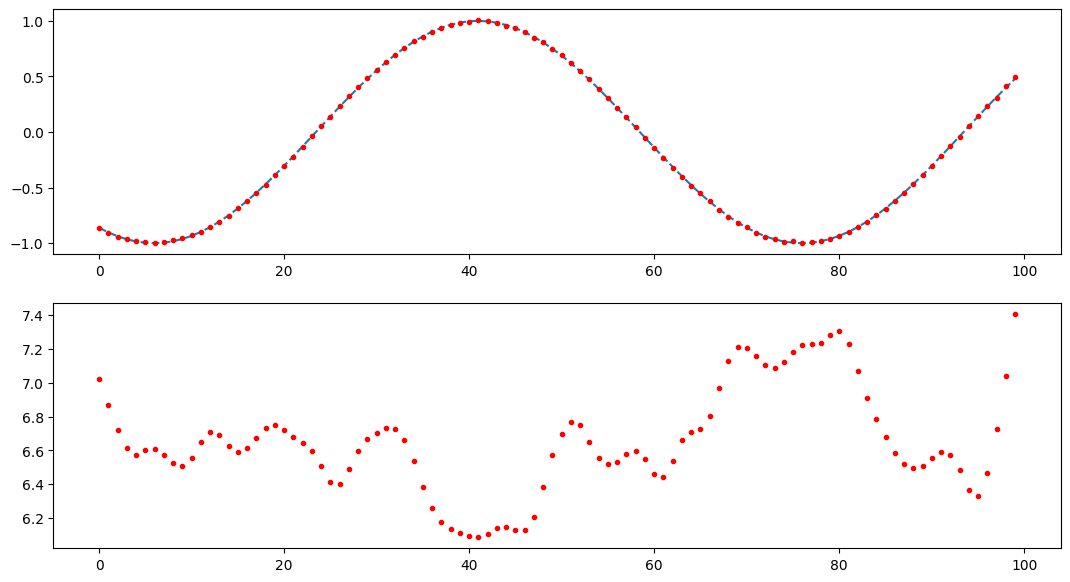

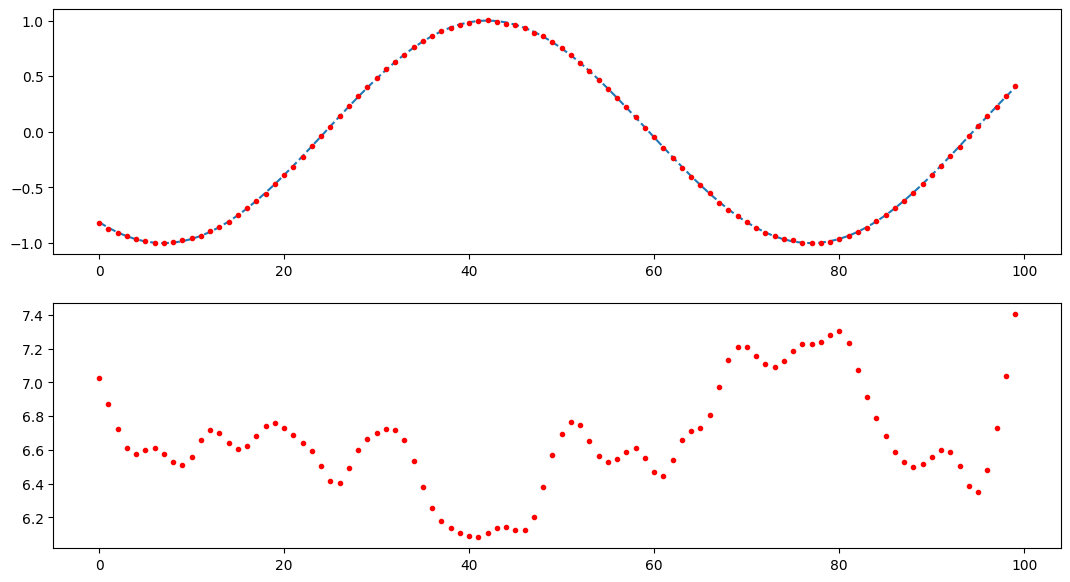

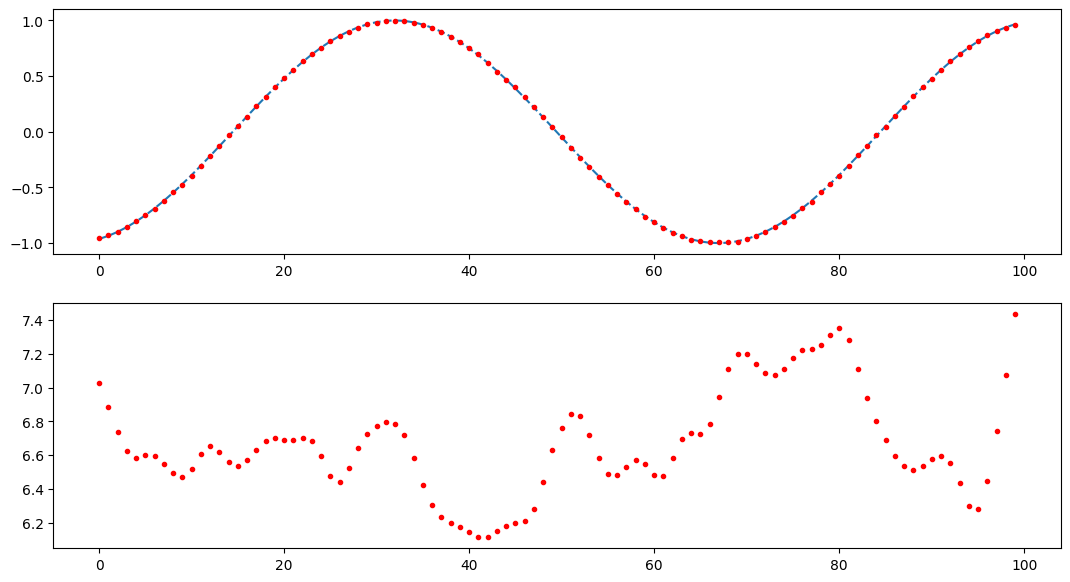

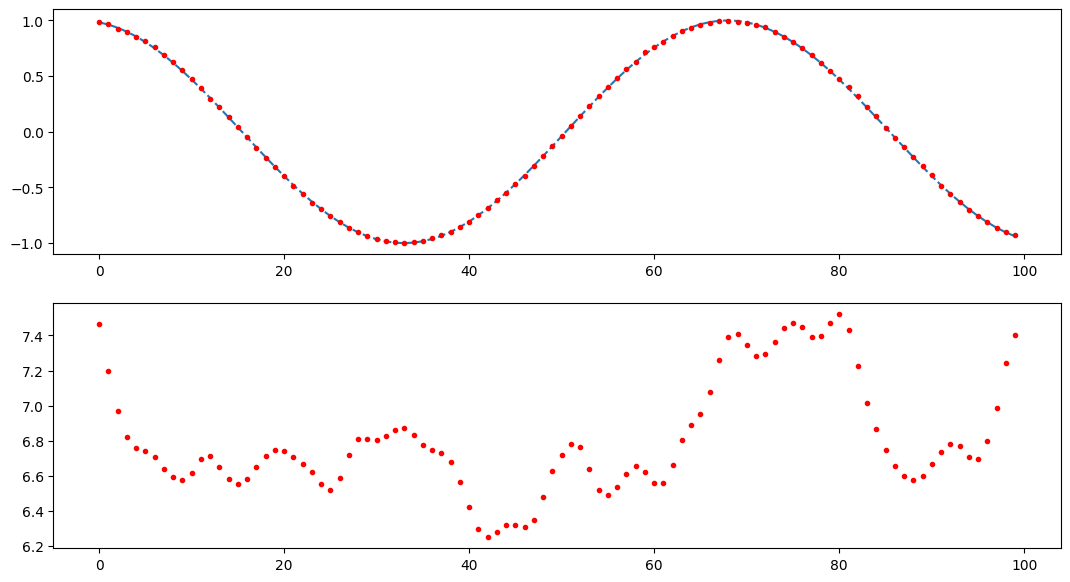

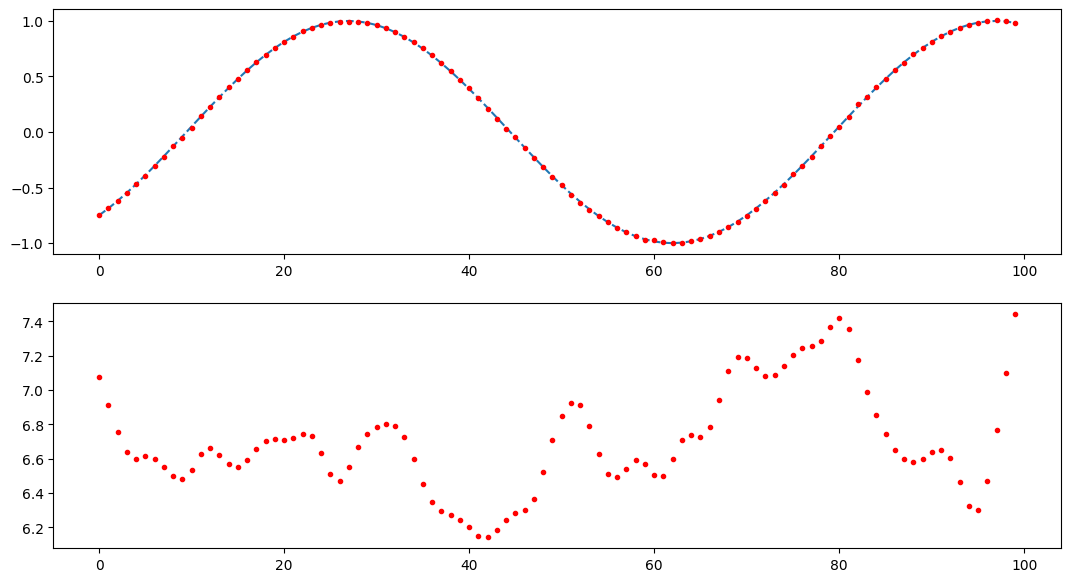

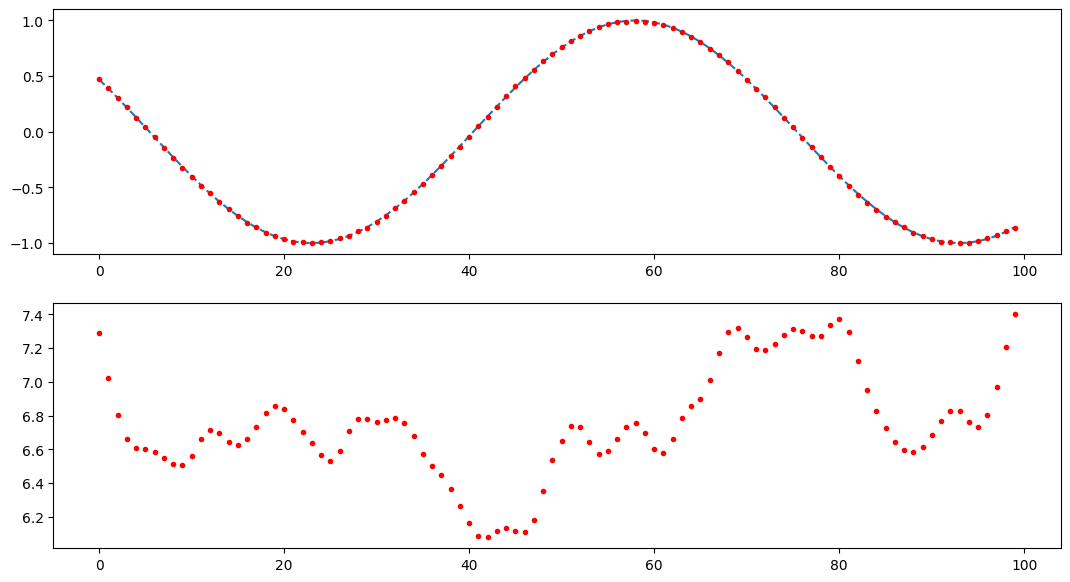

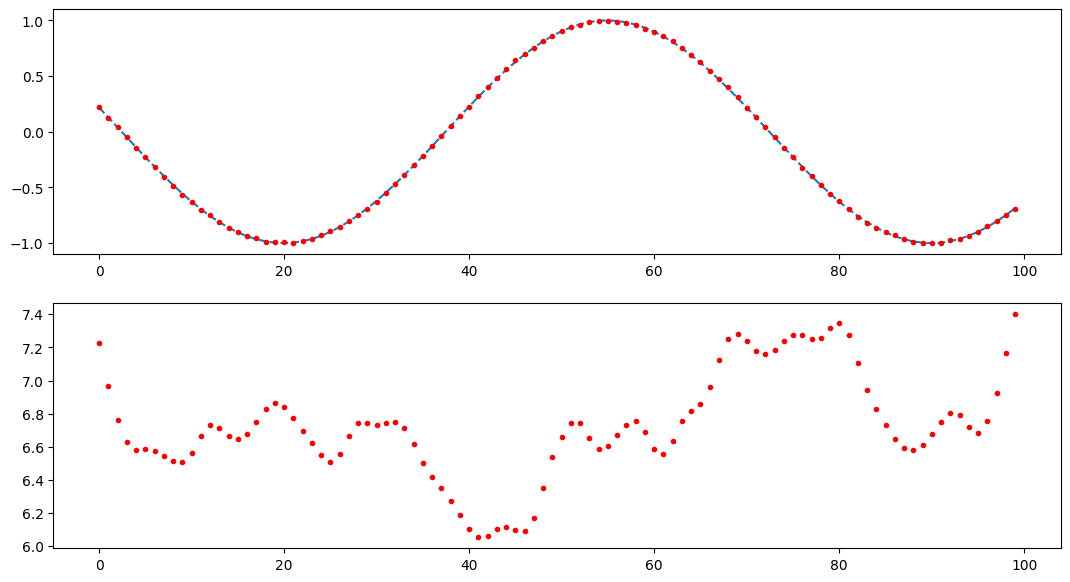

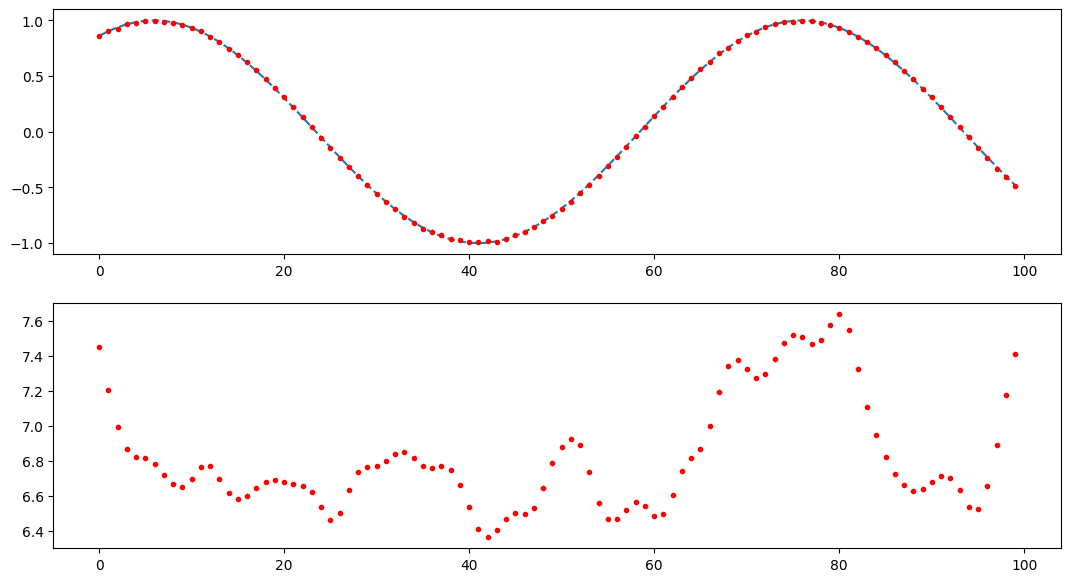

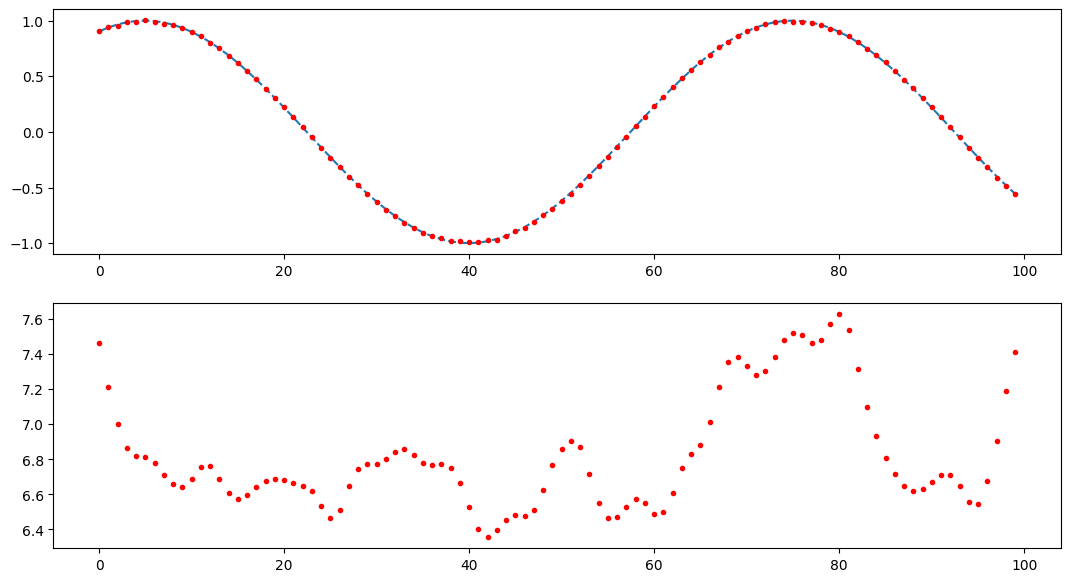

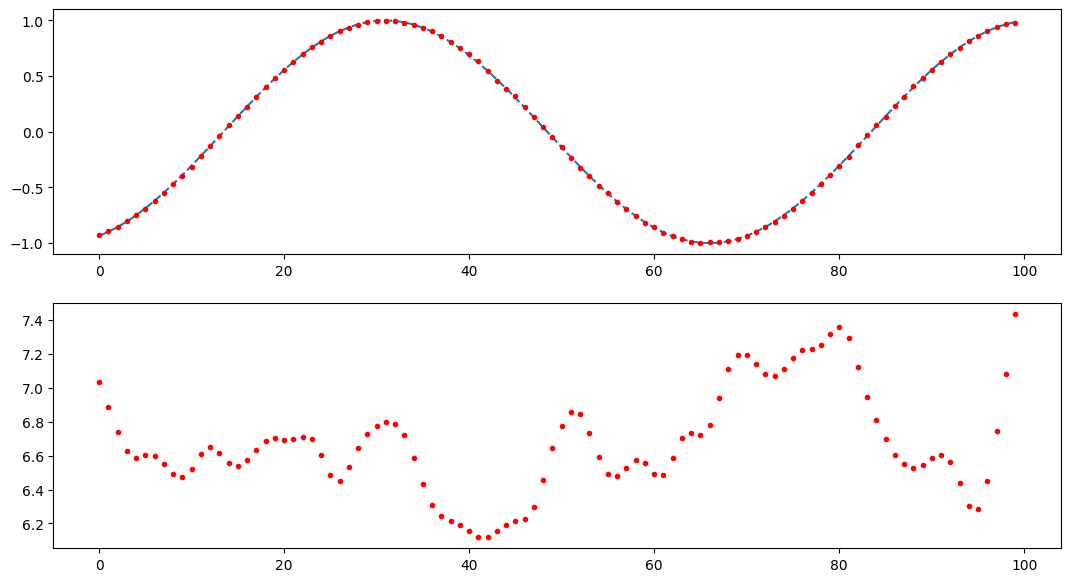

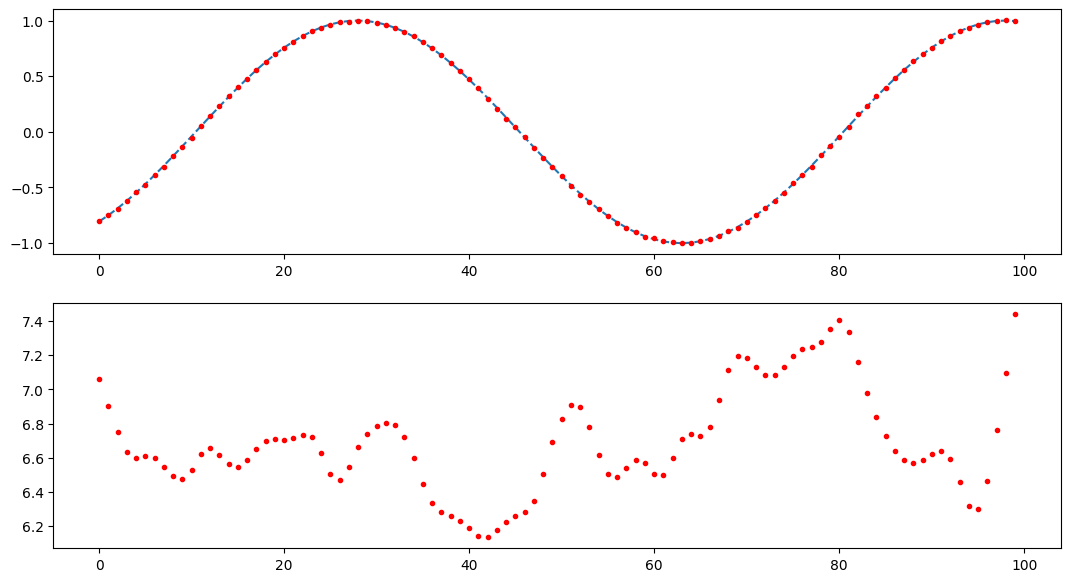

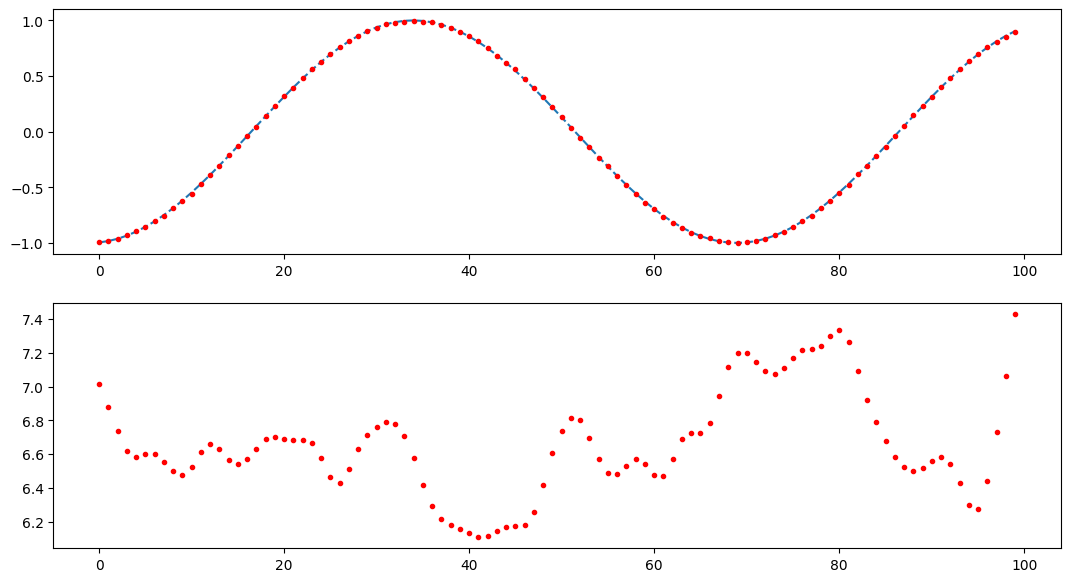

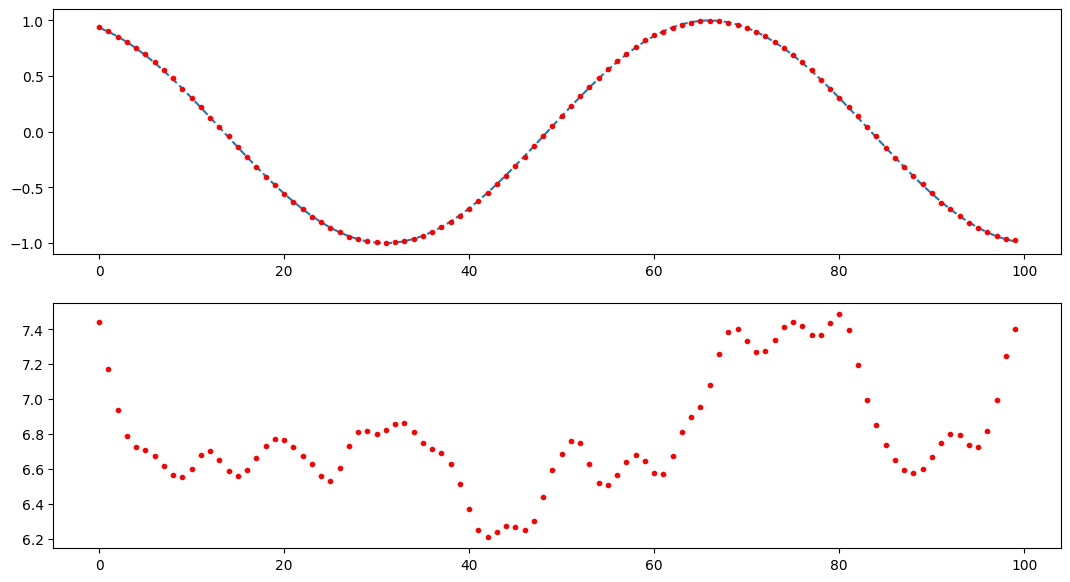

In [26]:
for n in range(23):
    plt.figure(figsize=(13,7))
    plt.subplot(2,1,1)
    plt.plot(b[n],"--")
    plt.plot(z[n],".r")
    plt.subplot(2,1,2)
    plt.plot(ass[n],".r")
    #plt.plot(crit_array[n],".r")

In [28]:
loss_array.shape

(3250, 2)

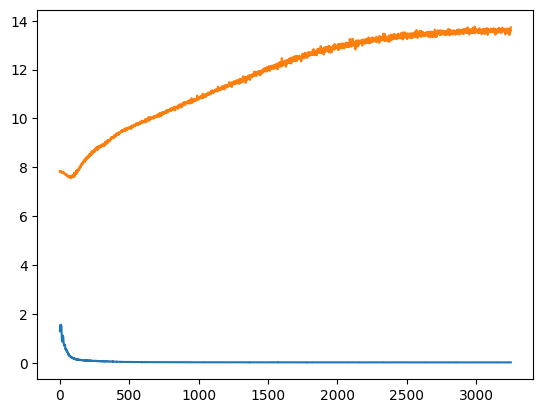

In [28]:
loss_array=np.array(loss_frob_diss)

plt.plot(loss_array[:])


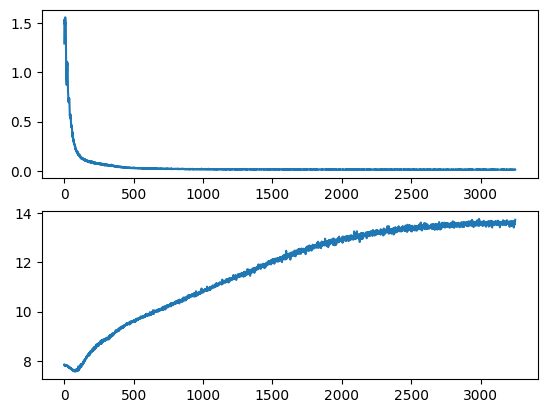

In [29]:
plt.subplot(2,1,1)
plt.plot(loss_array[:,0])
plt.subplot(2,1,2)
plt.plot(loss_array[:,1])

In [32]:
y[3][0][:,:,:,0].shape

torch.Size([32, 4, 100])

In [33]:
y[3][0][:,:,:,0].flatten().cpu().detach().numpy()

array([2.000033 , 2.000033 , 2.0000324, ..., 2.0000324, 2.0000315,
       2.0000317], dtype=float32)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

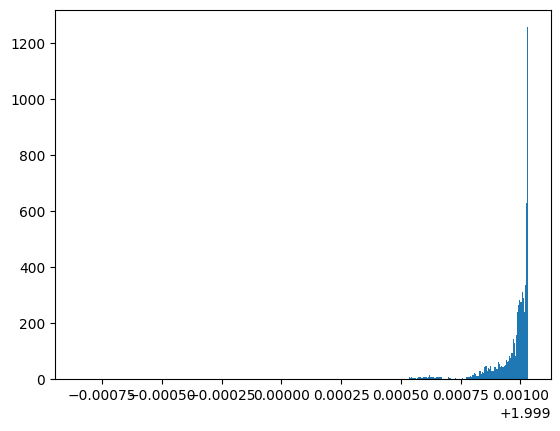

In [30]:
plt.hist(y[3][0][:,:,:,0].flatten().cpu().detach().numpy(),bins=400)

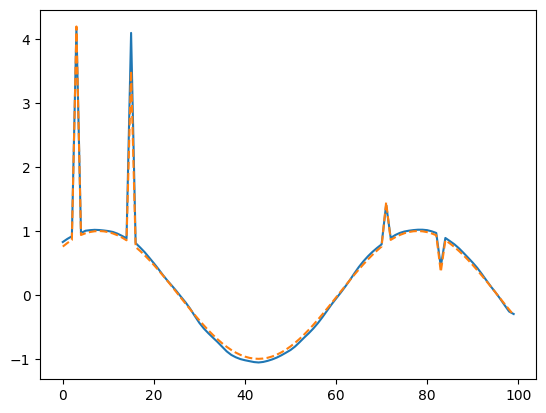

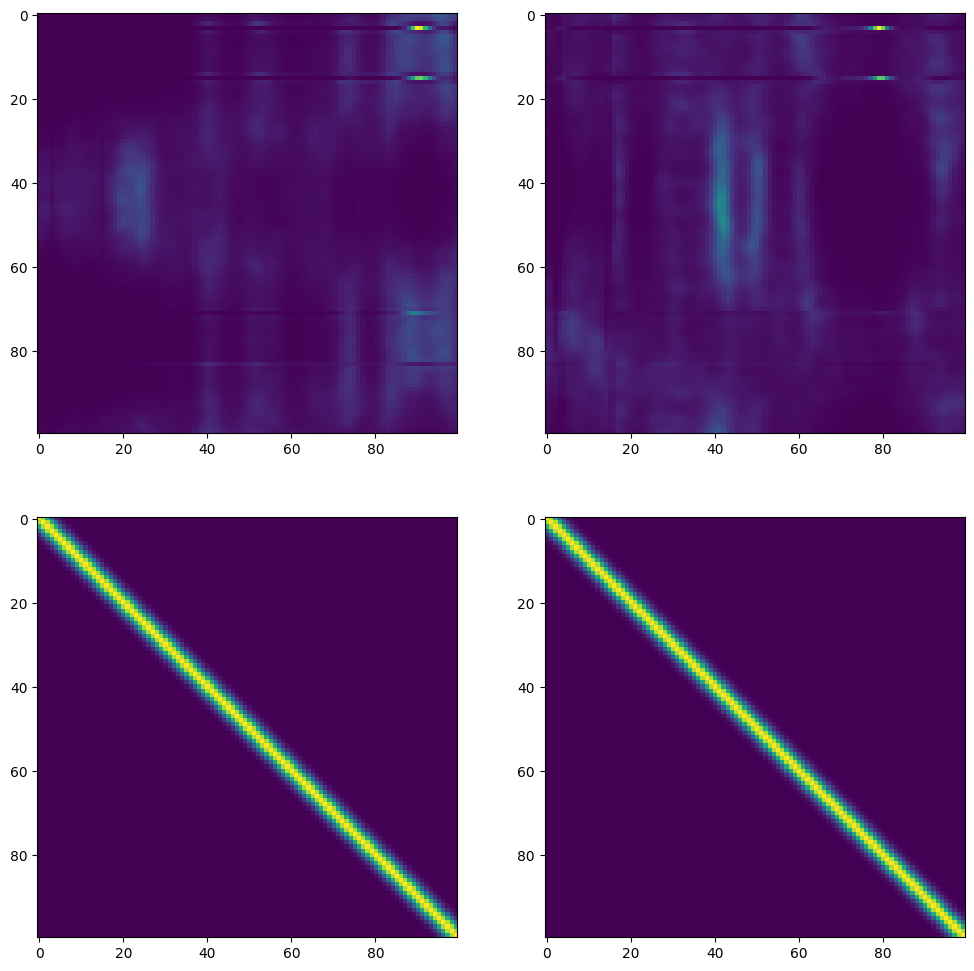

In [32]:
n=23

plt.plot(z[n])
plt.plot(b[n],"--")
plt.figure(figsize=(12,12))
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(series_aux[n][i])
    plt.subplot(2,2,i+3)
    plt.imshow(prior_aux[n][i])

Vale, esta prueba con una anomalía global a funcionado, ahora vamos a probar con algo más sutil, como un ligero valle, una anomalía contextual.